# Lecture 3: Further numerical experiments with Helmholtz


In [1]:
import math, numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scipyLA
import numpy.linalg as nLA
from easyFEMpkg.mesh import build_mesh
from easyFEMpkg.assemble import assemble_dirichlet, solve_system
from easyFEMpkg.plotting import show_mesh, trisurf_like, mesh_and_solution_side_by_side, trisurf_side_by_side
from easyFEMpkg.main import compute_error_norms

__Task 1:__ Play with the pollution effect!

We begin by considering the following problem: 

Find $u$ such that

$-\Delta u - k^2 u = 0$ in $\Omega$, with Dirichlet $u=g$ on $\partial\Omega$.

For simplicity, we will assume $k=\pi\omega$. In that case, by choosing g accordingly, the exact solution will be:
$$u(x,y) = \sin(kx/\sqrt{2})\sin(ky/\sqrt{2}).$$

In [2]:
 geometry = 'square'

#Set up the parameters for Helmholtz equation
omega = 2.0
k = np.pi*omega # wave number

# The code assumes it solves -Δu - c u = f.
# Helmholtz: -Δu - k^2 u = 0  => interior coefficient c(x,y) = -(k**2)
def c(x, y):
    return -(k**2)

# Set up Homogeneous Dirichlet data
def g(x, y):
    return math.sin(k/math.sqrt(2)*x)*math.sin(k/math.sqrt(2)*y)

In [3]:
# In order to consider different refinements, we need to pass a 'reference meshwidth'
h_ref = [0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.015625/2]
# Note that we haven't implemented an actual refinement routine. Instead, 
# we will be simply generating finer meshes (i.e. we will have a sequence of meshes that is not nested).

/home/curzuato/ownCloud2/TUD/Teaching/WavesSummerSchool2025/easyFEMpkg_mesh_PML_extension/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


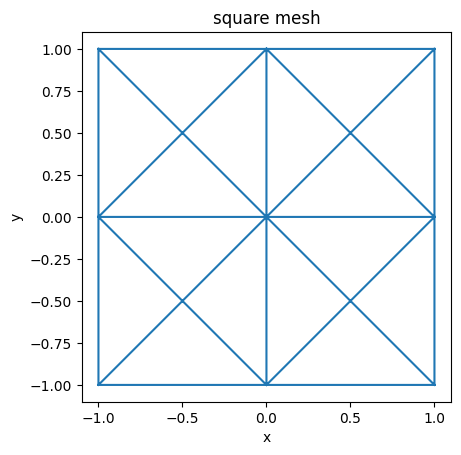

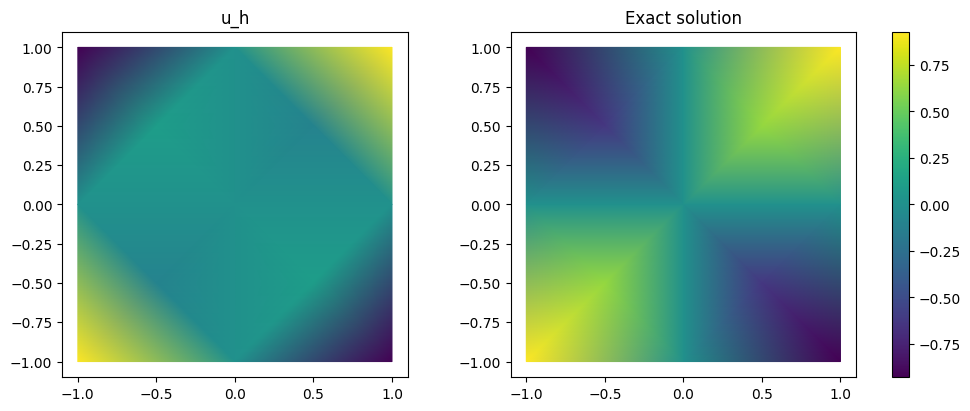

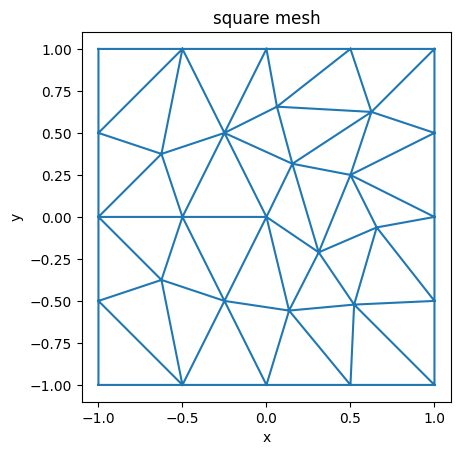

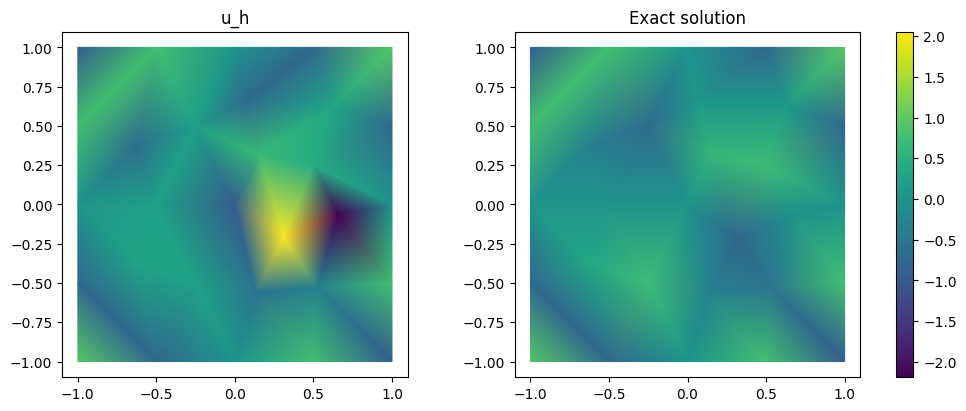

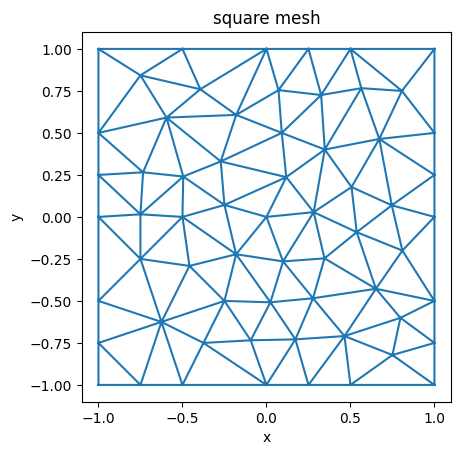

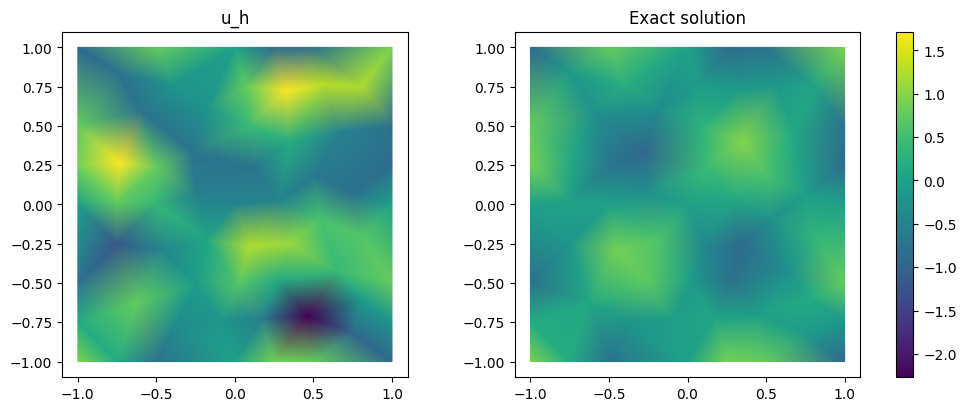

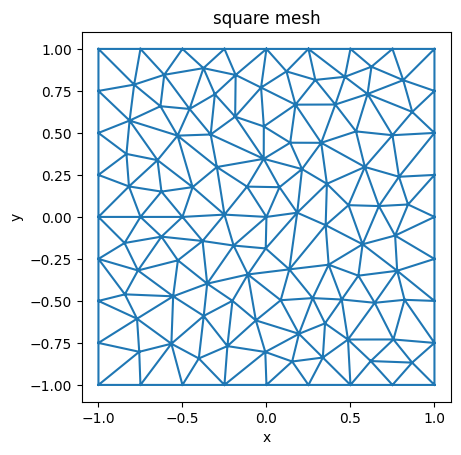

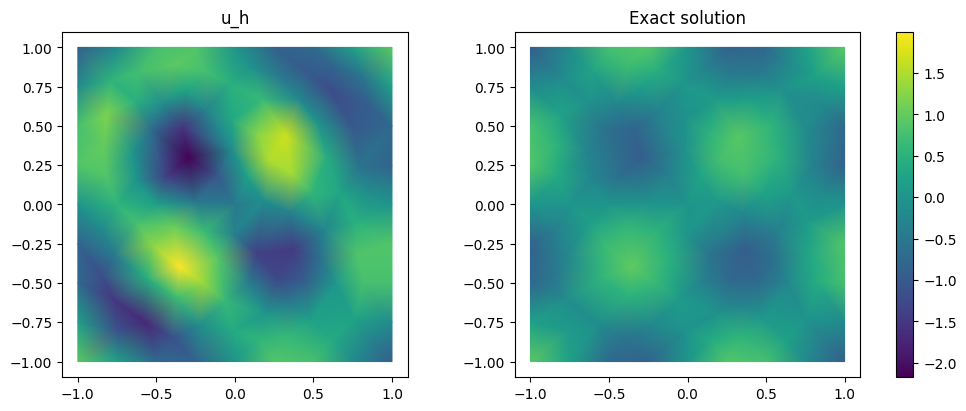

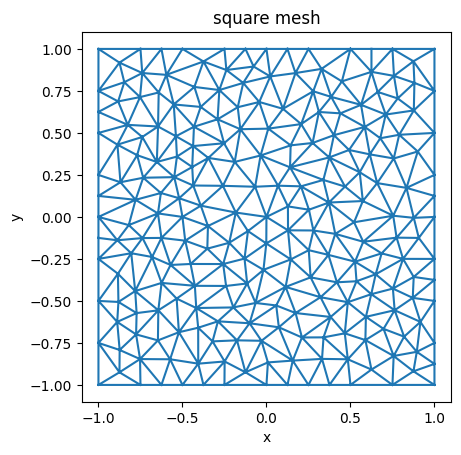

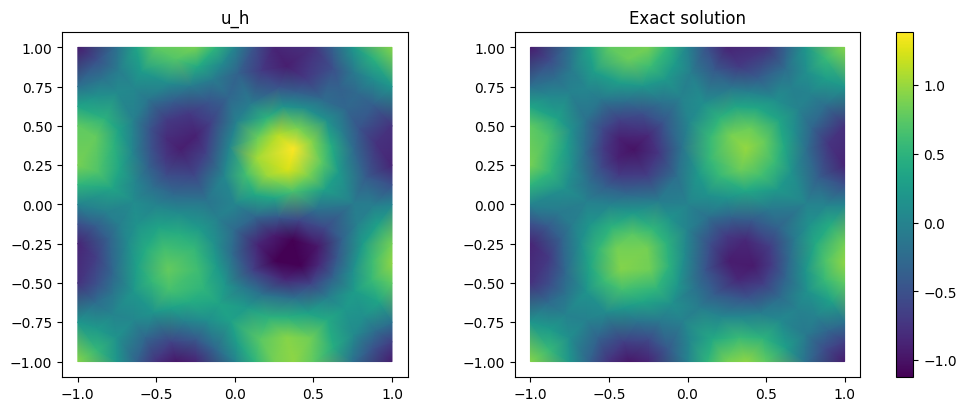

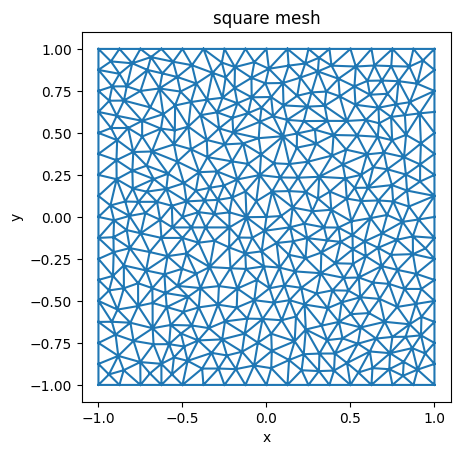

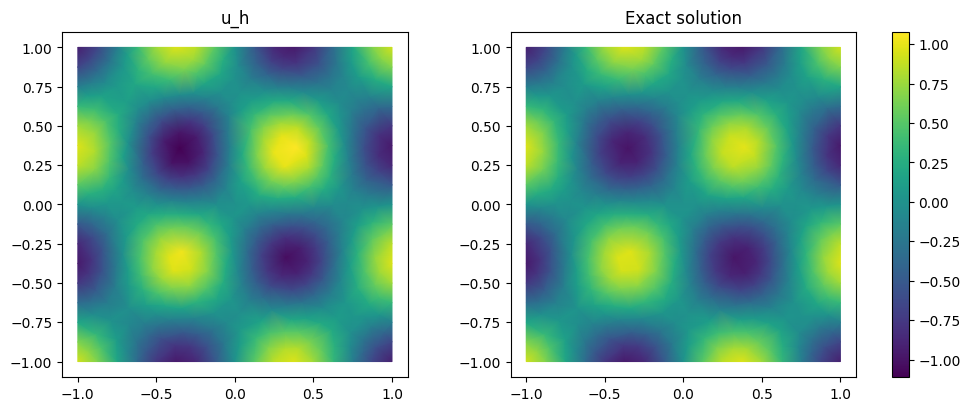

In [4]:
#Iterate over the different mesh refinements to see how the solution changes. We will compute the error as well.
L2_err = np.zeros(len(h_ref))
H1_err = np.zeros(len(h_ref))
m=0
for max_area in h_ref:
    # Build the mesh and retrieve the mesh data:
    # p: mesh vertices
    # t: mesh elements (this is an array containing the numbering of the vertices that belong to the triangle)
    # bnd: array containing the boundary edges. This will be used for setting boundary conditions when needed.
    p, t, bnd = build_mesh(geometry, max_area=max_area)
    
    # Assemble the system matrix S and the right hand side f. The code assumes it solves -Δu - c u = f. 
    # If no f is passed as argument, it assumes f=0.
    S, F = assemble_dirichlet(p, t, bnd, c, g)
    
    # Solve the system to find the coefficient vector
    u = solve_system(S, F)
    
    #Plot the mesh
    show_mesh(p, t, f"{geometry} mesh")
    
    #Plot the solution          
    u_ref = np.array([g(x,y) for (x,y) in p])
    trisurf_side_by_side(p, t, np.real(u), u_ref, titles=("u_h","Exact solution"))
    
    #Compute the error when compared to the reference solution (Exact solution = g)
    grad_exact=lambda x,y: (k/math.sqrt(2)*math.cos(k/math.sqrt(2)*x)*math.sin(k/math.sqrt(2)*y), 
                            k/math.sqrt(2)*math.sin(k/math.sqrt(2)*x)*math.cos(k/math.sqrt(2)*y))
    L2_err[m], H1_err[m] = compute_error_norms(p, t, np.real(u), g, grad_exact)
    m=m+1
    


Let us now see the convergence by plotting the errors.

[0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
[0.84820205 1.5098601  1.67425897 1.03723274 0.3768791  0.10346608]
[ 7.54698662  9.73915184 10.65729622  6.79910714  2.62325286  1.01036938]


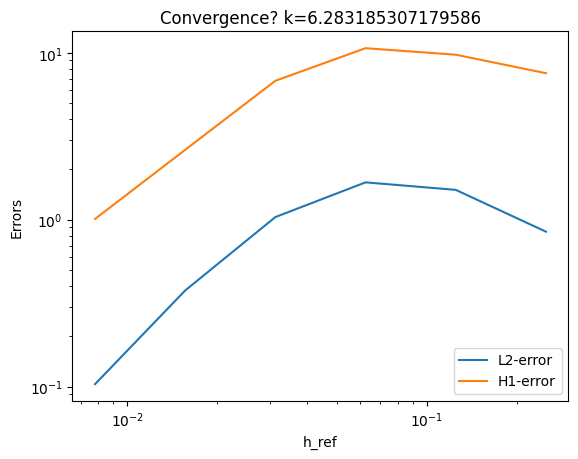

In [5]:
print(h_ref),print(L2_err), print(H1_err)

plt.loglog(h_ref, L2_err)
plt.loglog(h_ref, H1_err)
plt.title('Convergence? k='+str(k))
plt.xlabel('h_ref'); plt.ylabel('Errors')
plt.legend(["L2-error", "H1-error"], loc="lower right")
plt.show()

---
---

__Task 2:__ In lecture 2 we discussed that the interior Homogeneous-Dirichlet Helmholtz problem had uniqueness only when $k^2$ did not hit an eigenvalue of the Dirichlet Laplacian. 

Let us now play with the forbidden wavenumbers to see what this means numerically!

We therefore consider g=0 and $\Omega=(0,1)^2$. In that case, we have that the Dirichlet Laplacian has eigenfunctions $$u_m(x,y) = \sin(m\pi x)\sin(m \pi y),$$
with eigenvalues $\lambda_i=2\pi^2 m^2$, $m\in\mathbb{N}$.

So the issue will arise when $k=\pi m/\sqrt{2}$, $m\in\mathbb{N}$. Let us see what happens.

In [6]:
geometry = 'square'

#Set up the parameters for Helmholtz equation
m = 2.0
k = np.pi*m/math.sqrt(2)  # evil wave number

# The code assumes it solves -Δu - c u = f.
# Helmholtz: -Δu - k^2 u = 0  => interior coefficient c(x,y) = -(k**2)
def c(x, y):
    return -(k**2)

# Set up Homogeneous Dirichlet data
def g(x, y):
    return 0.0

# Let us choose a point source as our right hand side
def rhs(x, y):
    return math.exp(-10**2*((x-0.2)*(x-0.2)+y*y)) 

Rank: 5 , Size of S: 5 , null space of S 5
Printing the system matrix:
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 25 stored elements and shape (5, 5)>
  Coords	Values
  (0, 0)	(1+0j)
  (0, 1)	0j
  (0, 2)	0j
  (0, 3)	0j
  (0, 4)	0j
  (1, 0)	0j
  (1, 1)	(1+0j)
  (1, 2)	0j
  (1, 3)	0j
  (1, 4)	0j
  (2, 0)	0j
  (2, 1)	0j
  (2, 2)	(1+0j)
  (2, 3)	0j
  (2, 4)	0j
  (3, 0)	0j
  (3, 1)	0j
  (3, 2)	0j
  (3, 3)	(1+0j)
  (3, 4)	0j
  (4, 0)	(-1+0j)
  (4, 1)	(-1+0j)
  (4, 2)	(-1+0j)
  (4, 3)	(-1+0j)
  (4, 4)	(-2.5797362673929047+0j)


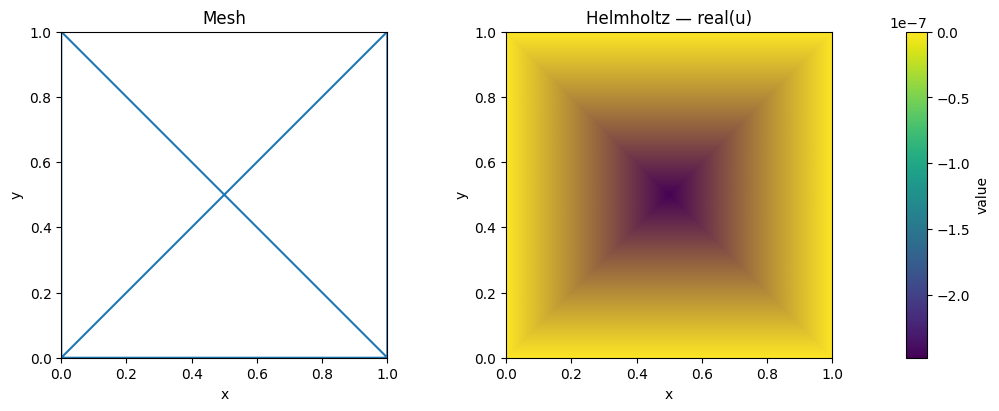

Rank: 9 , Size of S: 9 , null space of S 9
Printing the system matrix:
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 81 stored elements and shape (9, 9)>
  Coords	Values
  (0, 0)	(1+0j)
  (0, 1)	0j
  (0, 2)	0j
  (0, 3)	0j
  (0, 4)	0j
  (0, 5)	0j
  (0, 6)	0j
  (0, 7)	0j
  (0, 8)	0j
  (1, 0)	0j
  (1, 1)	(1+0j)
  (1, 2)	0j
  (1, 3)	0j
  (1, 4)	0j
  (1, 5)	0j
  (1, 6)	0j
  (1, 7)	0j
  (1, 8)	0j
  (2, 0)	0j
  (2, 1)	0j
  (2, 2)	(1+0j)
  (2, 3)	0j
  (2, 4)	0j
  (2, 5)	0j
  (2, 6)	0j
  :	:
  (6, 2)	0j
  (6, 3)	0j
  (6, 4)	0j
  (6, 5)	0j
  (6, 6)	(1+0j)
  (6, 7)	0j
  (6, 8)	0j
  (7, 0)	0j
  (7, 1)	0j
  (7, 2)	0j
  (7, 3)	0j
  (7, 4)	0j
  (7, 5)	0j
  (7, 6)	0j
  (7, 7)	(1+0j)
  (7, 8)	0j
  (8, 0)	0j
  (8, 1)	0j
  (8, 2)	0j
  (8, 3)	0j
  (8, 4)	0j
  (8, 5)	0j
  (8, 6)	0j
  (8, 7)	0j
  (8, 8)	(1+0j)


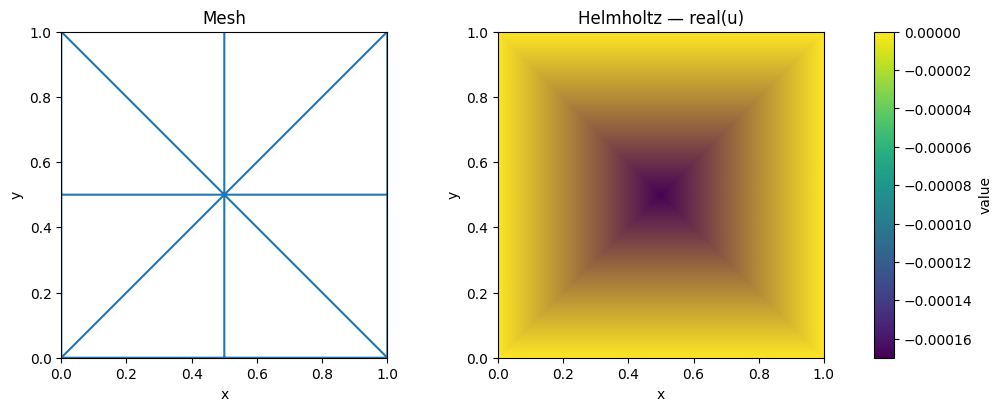

Rank: 13 , Size of S: 13 , null space of S 13
Printing the system matrix:
<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 133 stored elements and shape (13, 13)>
  Coords	Values
  (0, 0)	(1+0j)
  (0, 1)	0j
  (0, 2)	0j
  (0, 3)	0j
  (0, 4)	0j
  (0, 5)	0j
  (0, 6)	0j
  (0, 7)	0j
  (0, 8)	0j
  (0, 9)	0j
  (0, 10)	0j
  (0, 11)	0j
  (0, 12)	0j
  (1, 0)	0j
  (1, 1)	(1+0j)
  (1, 2)	0j
  (1, 3)	0j
  (1, 4)	0j
  (1, 5)	0j
  (1, 6)	0j
  (1, 7)	0j
  (1, 8)	0j
  (1, 9)	0j
  (1, 10)	0j
  (1, 11)	0j
  :	:
  (9, 3)	0j
  (9, 4)	0j
  (9, 5)	0j
  (9, 6)	0j
  (9, 7)	0j
  (9, 8)	0j
  (9, 9)	(1+0j)
  (9, 10)	0j
  (9, 11)	0j
  (9, 12)	0j
  (10, 3)	(-1+0j)
  (10, 4)	(-1+0j)
  (10, 5)	(-1+0j)
  (10, 7)	(-1+0j)
  (10, 10)	(2.355065933151774+0j)
  (11, 2)	(-1+0j)
  (11, 4)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 9)	(-1+0j)
  (11, 11)	(2.355065933151774+0j)
  (12, 1)	(-1+0j)
  (12, 4)	(-1+0j)
  (12, 6)	(-1+0j)
  (12, 9)	(-1+0j)
  (12, 12)	(2.355065933151774+0j)


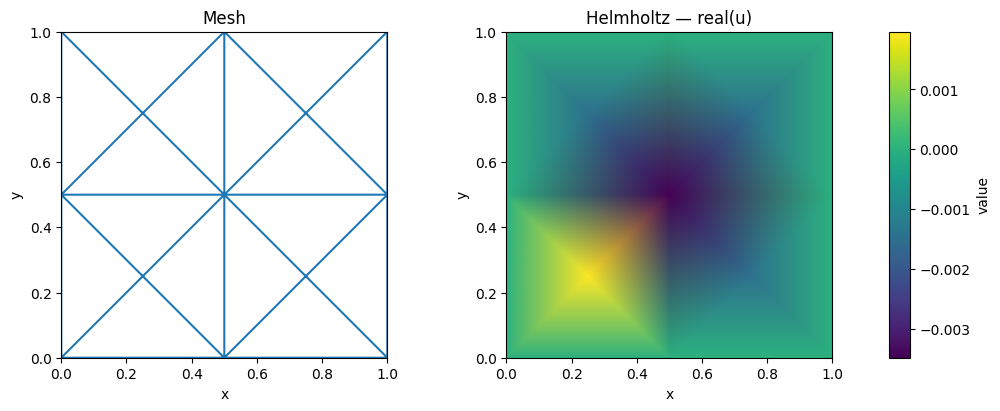

In [7]:
#Iterate over the different mesh refinements to see how the solution changes. We will compute the error as well.
#L2_err = np.zeros(len(h_ref))
#H1_err = np.zeros(len(h_ref))

h_ref = [0.25, 0.125, 0.0625]
for max_area in h_ref:
    # Build the mesh and retrieve the mesh data:
    # p: mesh vertices
    # t: mesh elements (this is an array containing the numbering of the vertices that belong to the triangle)
    # bnd: array containing the boundary edges. This will be used for setting boundary conditions when needed.
    p, t, bnd = build_mesh(geometry, max_area=max_area, box=(0,1,0,1))
    
    # Assemble the system matrix S and the right hand side f. The code assumes it solves -Δu - c u = f. 
    # If no f is passed as argument, it assumes f=0.
    S, F = assemble_dirichlet(p, t, bnd, c, g, rhs)
    
    # Compute some information about the matrix to understand what is happening
    S_aux = S.todense()
    nullspace = scipyLA.null_space(S_aux)
    rank = nLA.matrix_rank(S_aux)
    print('Rank:',rank, ', Size of S:', len(S_aux), ', null space of S',len(nullspace))
    
    # Print the matrix to have a closer look
    print('Printing the system matrix:')
    print(S)
    
    # Solve the system to find the coefficient vector
    u = solve_system(S, F)
    
    #Plot the solution          
    mesh_and_solution_side_by_side(p, t, np.real(u), title="Helmholtz — real(u)")
    
